# Importing the libraries

There are a lot of libraries that I used. I should double check if all of them are required in the end because there was quite some back and forth in this notebook

In [1]:
import numpy as np
import os

import ee
import geemap
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.transform import from_origin


import rioxarray as rxr
import xarray as xr

from rasterio.features import shapes
from shapely.geometry import shape


import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import HTML

from skimage import morphology
from skimage.morphology import (
    binary_closing,
    binary_erosion,
    binary_dilation,
    remove_small_objects,
    remove_small_holes,
    disk
)
from pyproj import Transformer

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import json
import pickle 




# Earth Engine

### Initialisation

First, we need to authenticate with Google Earth Engine. You just need to create an account and then the following cell should forward you to GEE where you can get your API key. I am using VSCode which will prompt you to enter the code at the top. This can be a bit hard if you are not expecting it. Entering the token will allow you to access GEE from your notebook.

In [3]:
# Authenticate with Google Earth Engine
ee.Authenticate()
# Initialize Earth Engine
ee.Initialize()



Successfully saved authorization token.


Next, we prepare the area of interest. We can use https://geojson.io/ to get the coordinates.

### Defining the Cloud Mask

In the following, we download the data and introduce a cloud mask. For the cloud mask, we follow https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/sentinel-2-s2cloudless/index.ipynb 

It is quite lengthy, but basically, we use the S2_CLOUD_PROBABILITY data to identify clouds and use the SLC band to identify clouds and then create a mask to remove said pixels.

In [13]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select(['B2', 'B3', 'B4', 'B8', 'B12','SCL']).updateMask(not_cld_shdw)

Time to set the parameter of the cloud mask and the area of interest. We can use https://geojson.io/ to get the coordinates.

In [14]:
# Exact area of interest (AOI) in Tasmania, Australia
aoi = ee.Geometry.Rectangle([144.7409, -41.9034, 145.6099, -41.1621])  # Adjust as needed

# Roughly the area of interest (AOI) in Tasmania, Australia
AOI_rectangle = [144.73, 145.155, -41.77, -41.29]
# Define the bounding box coordinates
min_lat, max_lat = -41.9034, -41.1621
min_lon, max_lon = 144.7409, 144.7409

AOI = ee.Geometry.Rectangle(AOI_rectangle)
# Define the start and end dates for the image collection
START_DATE = start_date
END_DATE = end_date
# This parameter is used to filter the image collection by cloud cover percentage.
# The value is set to 60, meaning that only images with a cloud cover percentage of 60% or less will be included in the collection.
CLOUD_FILTER = 60
# This parameter is used to set the threshold for cloud probability.
# The value is set to 40, meaning that pixels with a cloud probability of 40% or higher will be considered as clouds.
CLD_PRB_THRESH = 40
# This parameter is used to set the threshold for dark NIR pixels.
# The value is set to 0.15, meaning that pixels with a NIR value of 0.15 or lower will be considered as dark pixels.
NIR_DRK_THRESH = 0.15
# This parameter is used to set the distance for cloud projection.
# The value is set to 2, meaning that the cloud projection will be 2 pixels away from the cloud.
CLD_PRJ_DIST = 2
# This parameter is used to set the buffer size for dilating the cloud-shadow mask.
# The value is set to 100, meaning that the cloud-shadow mask will be dilated by 100 pixels.
BUFFER = 100

Here, I have a quick helper function that uses GEE to plot the area of interest and plot the NBR as well as the RGB image

In [18]:
def plot_dataset(s2):
   
    nbr = s2.expression(
        "(B8 - B12) / (B8 + B12)",
        {
            "B8": s2.select("B8"),    # Near-Infrared (NIR)
            "B12": s2.select("B12")   # Shortwave Infrared (SWIR)
        }
    ).rename("NBR")

   
   # Define RGB Visualization Parameters
    rgb_vis = {
    "bands": ["B4", "B3", "B2"],  # True color (Red, Green, Blue)
    "min": 0, "max": 1000,  # Normalize RGB range
    }

    # Define NBR Visualization Parameters
    nbr_vis = {
        "min": -1, "max": 1,  # Normalize NBR range
        "palette": ["red", "yellow", "green"]  # Burned areas (Red), Healthy vegetation (Green)
    }

    m = geemap.Map()
    m.set_center(145.323,-41.523, 9)
    # Add Layers: RGB and NBR
    m.addLayer(s2, rgb_vis, "RGB Sentinel-2")
    m.addLayer(nbr, nbr_vis, "Normalized Burn Ratio (NBR)")    
    return m

### Download and Plots

We can now access the data through GEE and plot the results. It might take a moment until the RGB and NBR are showing depending on your internet speed. The RGB tends to be a bit dark without any pre-processing

In [ ]:
# Load data from before the fire
s2_sr_cld_col = get_s2_sr_cld_col(AOI, start_date='2025-01-01', end_date='2025-02-01') # Get the S2 collection
data_pre = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())
data_pre = data_pre.clip(aoi)

# Load data from after the fire
s2_sr_cld_col = get_s2_sr_cld_col(aoi, start_date='2025-02-20',end_date='2025-04-01') # Get the S2 collection
data_post = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())
data_post = data_post.clip(aoi)
# Plot if necessary to check that area looks ok
#plot_dataset(data_post)
#plot_dataset(data_pre)


Map(center=[-41.523, 145.323], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

This was actually, the only time we need to access Google Earth Engine. We can now download the data into .tif-files and do any further analysis without GEE. Exporting images to your local driver places a limit on the size you can download. To get the images that we want, we increase the scale/resolution to 100m, which is still more than enough for our purposes. Later on, we will do the fire simulation on a 250m grid.

In [ ]:
# Save download to .tif file for further processing. We keep additional 
# bands for further processing. The SCL band is the cloud mask band.
geemap.ee_export_image(data_post.select(['B2', 'B3', 'B4', 'B8', 'B12','SCL']), filename='output/cloud_free_sentinel2_post.tif', scale=100, file_per_band=False)
geemap.ee_export_image(data_pre.select(['B2', 'B3', 'B4', 'B8', 'B12','SCL']), filename='output/cloud_free_sentinel2.tif', scale=100, file_per_band=False)


Generating URL ...
Please wait ...
Data downloaded to c:\Users\juliu\Desktop\Coding\Bushfire\output\cloud_free_sentinel2.tif


### Import

Now if we are happy with the data that we got (we might need to change to a longer timeframe if there is too much cloud coverage), we can continute the work from this checkpoint.

We start by reading the data and working creating a water mask. The pre fire image SLC shows a lot clouds, but the images are actually not that polluted. Just when you take the median of the SLC it sometimes does some weird things. We combine the both SLC maps to create a water mask. If either of the SLC maps whos water, it'll show in the mask. Looking at the image below, we see that the water mask looks reasonable when comparing with the RGB above.

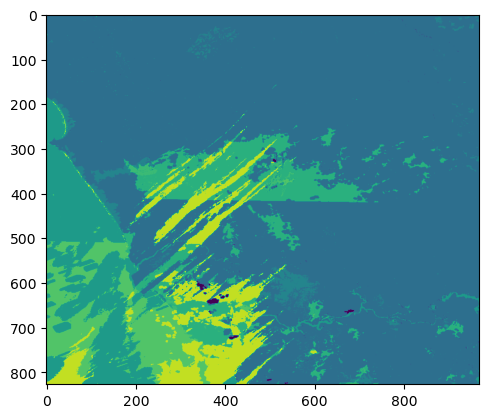

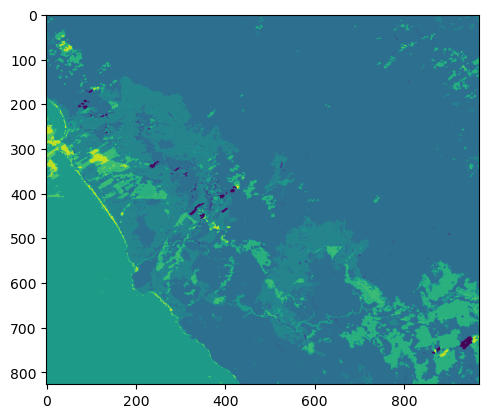

In [4]:
image_path = "output/cloud_free_sentinel2.tif"  # Update with your file path
# Open the file using rasterio 
with rasterio.open(image_path) as src:
    SCL0 = src.read(6).astype(np.float32)  # SLC (Scene Classification Layer) used for the water mask
plt.imshow(SCL0)
plt.show()

image_path = "output/cloud_free_sentinel2_post.tif"  # Update with your file path
with rasterio.open(image_path) as src:
    SCL1 = src.read(6).astype(np.float32)  # SLC (Scene Classification Layer) used for the water mask
plt.imshow(SCL1)
plt.show()

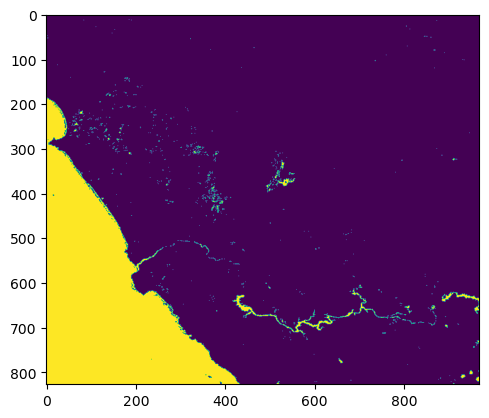

In [5]:
# Create binary water masks (1 for water, 0 for non-water)
water_mask0 = (SCL0 == 6).astype(np.uint8)
water_mask1 = (SCL1 == 6).astype(np.uint8)

# Combine both masks using logical OR. Water is where either of the mask show water. So if in one of the images are clouds, we can see underneath them.
combined_water_mask = np.logical_or(water_mask1, water_mask0).astype(np.uint8)

plt.imshow(combined_water_mask)
plt.show()
# note that the image looks a bit patchy but there are small lakes and other water bodies in the area.

### Plots

Now that we have the fully pre-processed, we can start the analyse. We will first plot the RGB picture and the NBR before and after the fire. Then we will compare the NBR next to each other. Finally, we will calculate the dNBR and plot it.

C:\Users\juliu\AppData\Local\Temp\ipykernel_22096\2110665939.py:21: RuntimeWarning: invalid value encountered in divide
  nbr = (nir - swir) / (nir + swir)
C:\Users\juliu\AppData\Local\Temp\ipykernel_22096\2110665939.py:23: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir - red)/(nir + red)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


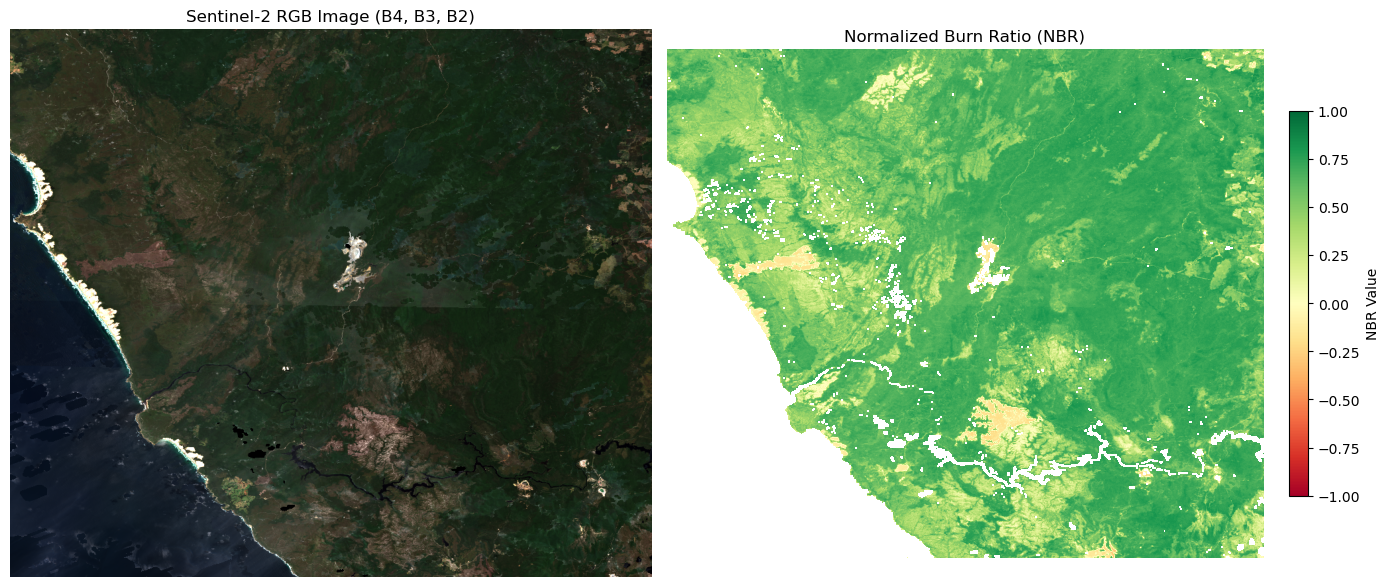

In [6]:
# Load the GeoTIFF file
image_path = "output/cloud_free_sentinel2.tif"  # Update with your file path

# Open the file using rasterio
with rasterio.open(image_path) as src:
    red = src.read(3).astype(np.float32)  # B4 (Red)
    green = src.read(2).astype(np.float32)  # B3 (Green)
    blue = src.read(1).astype(np.float32)  # B2 (Blue)
    nir = src.read(4).astype(np.float32)  # B8 (NIR)
    swir = src.read(5).astype(np.float32)  # B12 (SWIR)

# Normalize function to scale data between 0-1 for display
def normalize(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))

# Normalize RGB bands
rgb_image = np.stack([normalize(red)*3, normalize(green)*3, normalize(blue)*3], axis=-1)

# Compute NBR using the formula: (NIR - SWIR) / (NIR + SWIR), avoiding division by zero
#nbr = np.where((nir + swir) != 0, (nir - swir) / (nir + swir), np.nan)
nbr = (nir - swir) / (nir + swir)
nbr_masked= np.where(combined_water_mask==1, np.nan, nbr)
NDVI = (nir - red)/(nir + red)
# Set up the plot with two subplots (RGB & NBR)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the RGB image
axes[0].imshow(rgb_image)
axes[0].set_title("Sentinel-2 RGB Image (B4, B3, B2)")
axes[0].axis("off")

# Plot the NBR image
nbr_plot = axes[1].imshow(nbr_masked, cmap="RdYlGn", vmin=-1, vmax=1)
axes[1].set_title("Normalized Burn Ratio (NBR)")
axes[1].axis("off")

# Add colorbar for NBR
cbar = plt.colorbar(nbr_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("NBR Value")

# Show the plot
plt.tight_layout()
plt.show()


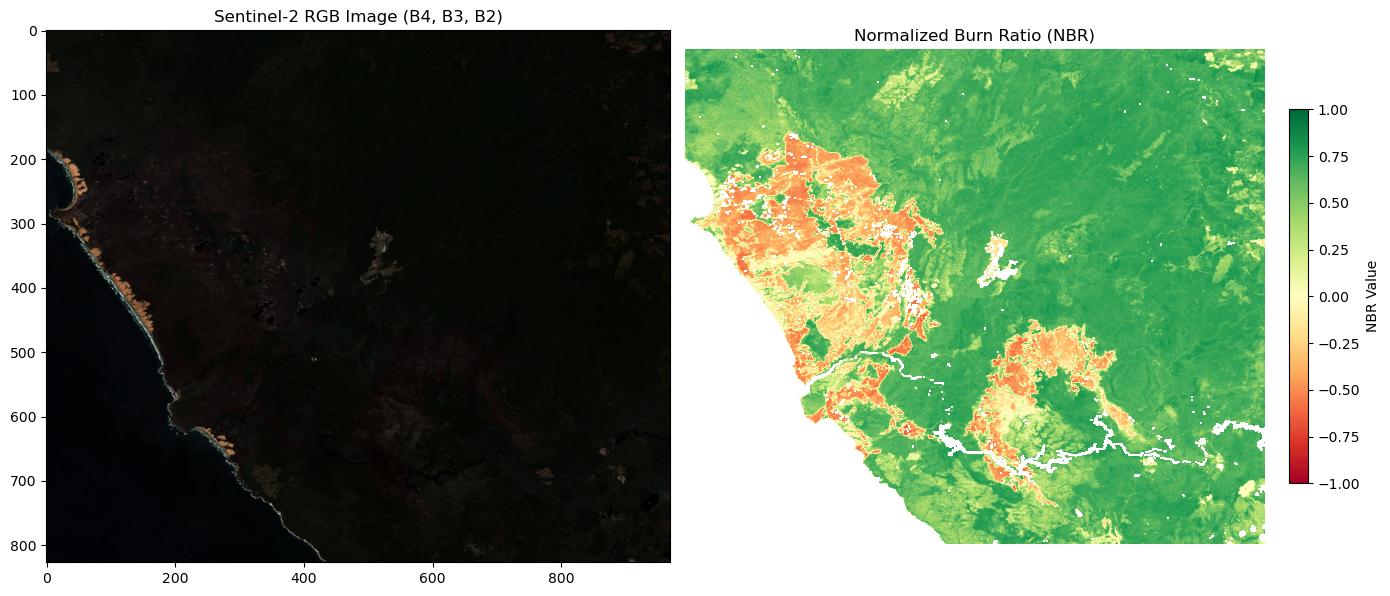

In [7]:
# Load the GeoTIFF file
image_path = "output/cloud_free_sentinel2_post.tif"  # Update with your file path

# Open the file using rasterio
with rasterio.open(image_path) as src:
    red1 = src.read(3).astype(np.float32)  # B4 (Red)
    green1 = src.read(2).astype(np.float32)  # B3 (Green)
    blue1 = src.read(1).astype(np.float32)  # B2 (Blue)
    nir1 = src.read(4).astype(np.float32)  # B8 (NIR)
    swir1 = src.read(5).astype(np.float32)  # B12 (SWIR)

# Normalize function to scale data between 0-1 for display
def normalize(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))

# Normalize RGB bands
rgb_image1 = np.stack([normalize(red1), normalize(green1), normalize(blue1)], axis=-1)

# Compute NBR using the formula: (NIR - SWIR) / (NIR + SWIR), avoiding division by zero
#nbr = np.where((nir + swir) != 0, (nir - swir) / (nir + swir), np.nan)
nbr1 = (nir1 - swir1) / (nir1 + swir1+1e-10)  # Adding a small value to avoid division by zero
nbr1_masked= np.where(combined_water_mask==1, np.nan, nbr1)

# Set up the plot with two subplots (RGB & NBR)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the RGB image
axes[0].imshow(rgb_image1)
axes[0].set_title("Sentinel-2 RGB Image (B4, B3, B2)")
#axes[0].axis("off")

# Plot the NBR image
nbr_plot = axes[1].imshow(nbr1_masked, cmap="RdYlGn", vmin=-1, vmax=1)
axes[1].set_title("Normalized Burn Ratio (NBR)")
axes[1].axis("off")

# Add colorbar for NBR
cbar = plt.colorbar(nbr_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("NBR Value")

# Show the plot
plt.tight_layout()
plt.show()


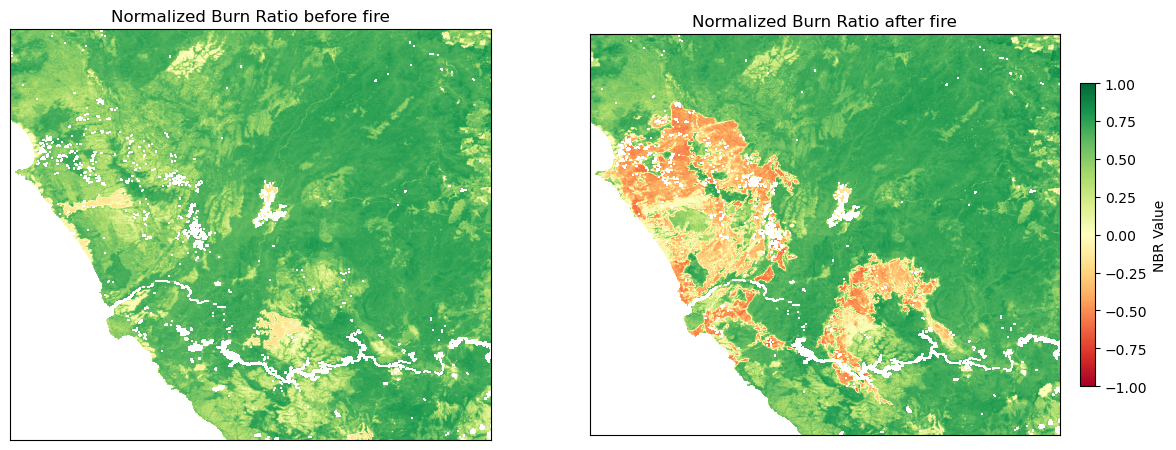

In [8]:
# Set up the plot with two subplots (RGB & NBR)
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1.05]})

# Plot the NBR image before fire
nbr_plot = axes[0].imshow(nbr_masked, cmap="RdYlGn", vmin=-1, vmax=1)
axes[0].set_title("Normalized Burn Ratio before fire")
axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and tick markers

# Plot the NBR image after fire
nbr_plot1 = axes[1].imshow(nbr1_masked, cmap="RdYlGn", vmin=-1, vmax=1)
axes[1].set_title("Normalized Burn Ratio after fire")
axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and tick markers

# Add colorbar for NBR
cbar = plt.colorbar(nbr_plot1, ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("NBR Value")

# Save the figure
plt.savefig('img/bushfire/NBR_double.png', dpi=300, bbox_inches='tight')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


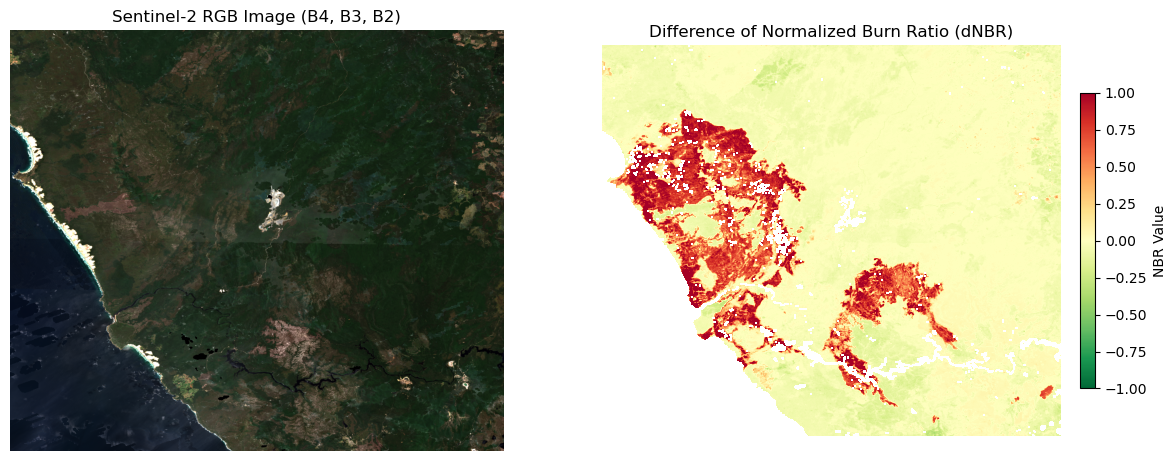

In [9]:
# Show the change in NBR
# Set up the plot with two subplots (RGB & NBR)
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Plot the RGB image
axes[0].imshow(rgb_image)
axes[0].set_title("Sentinel-2 RGB Image (B4, B3, B2)")
axes[0].axis("off")

dnbr = (nbr_masked-nbr1_masked)

# Plot the NBR image
dnbr_plot = axes[1].imshow(dnbr, cmap="RdYlGn_r", vmin=-1, vmax=1)
axes[1].set_title("Difference of Normalized Burn Ratio (dNBR)")
axes[1].axis("off")

# Add colorbar for NBR
cbar = plt.colorbar(dnbr_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("NBR Value") 

# Show the plot
#plt.tight_layout()
plt.show()

### Touching up the Burn Area

We now have the area that has burned. In the next step, we want to make the burn area a bit cleaner. We smoothen out the patches, fill tiny holes and remove tiny patches. The final result will then be saved as a vector file and as a raster file. The vector file is light weight and good for plotting in applications like QGIS. The raster file can be used for further calculations.

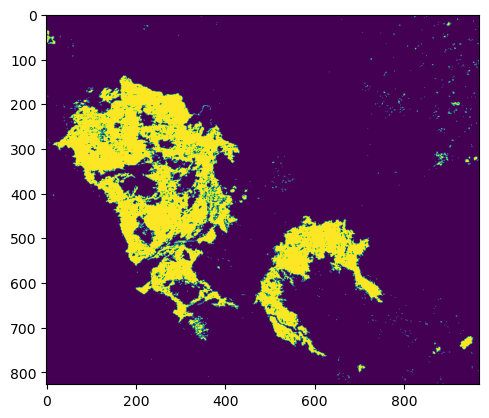

The burnt area in hectar is: 801357


In [10]:
# Decide on a threshold for the change detection
# we can play around a bit with the threshold, but we see that the results are not very sensitive to it.
threshold = 0.1
dnbr_thres = np.where(dnbr>threshold, dnbr, np.nan)
# Get as mask with 1 and zeros
dnbr_thres_0_1 = np.where(dnbr>threshold, 1, 0)

rgb_area = np.zeros_like(rgb_image1)
plt.imshow(dnbr_thres_0_1)
plt.show()

# Quick calculation to see the total area burnt calculated from the resolution and the number of pixels
# The fire was around 900.000 ha, but also includes another patch that was outside of our area. So I guessm we mapped it quite well.
burnt_pixel = np.count_nonzero(dnbr) # pixel
scale = 100**2 # m2/pixel
m2_to_hecta = 0.0001
burnt_area_ha = burnt_pixel*scale*m2_to_hecta
print('The burnt area in hectar is: {}'.format(int(burnt_area_ha)))

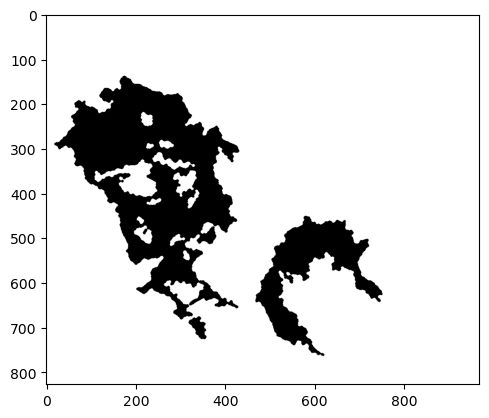

In [11]:
# Make the area a bit prettier in 4 steps

# Define structuring element (3-pixel radius disk-shaped)
selem = disk(3)

# Step 1: Close small holes and gaps
closed = binary_closing(dnbr_thres_0_1, selem)

# Step 2: Erode then dilate to smooth edges
eroded = binary_erosion(closed, selem)
dilated = binary_dilation(eroded, selem)

# Step 3: Remove small objects (noise) — e.g., fewer than 500 pixels
no_small_objects = remove_small_objects(dilated, min_size=100)

# Step 4: Fill small holes — e.g., holes smaller than 100 pixels
smoothed = remove_small_holes(no_small_objects, area_threshold=100)

smoothed = remove_small_objects(smoothed, min_size=500)



# Now `smoothed` is your final cleaned burnt area mask
plt.imshow(smoothed, cmap='gray_r')
plt.show()

The result now looks very similar to the one reported in the Newspaper article. We have the croissant on the right and blob on the left.

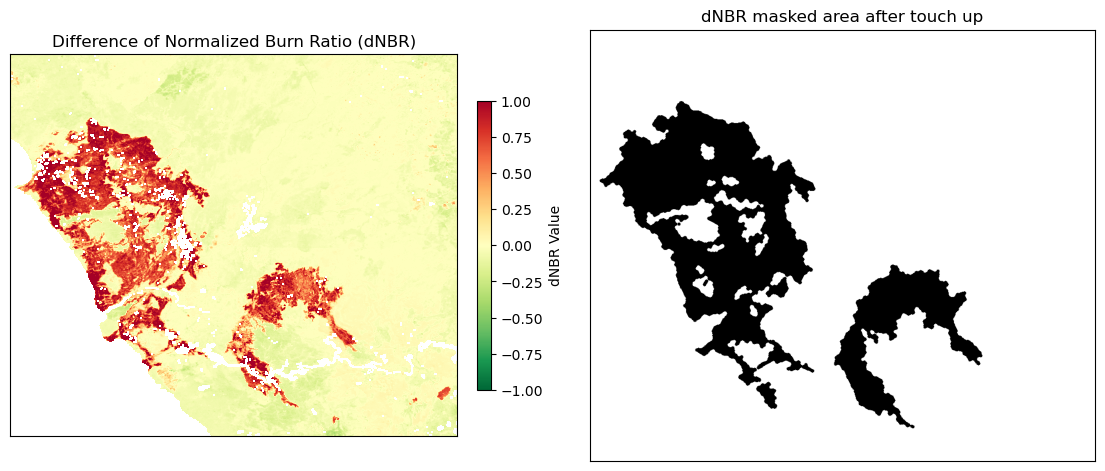

In [ ]:
# Set up the plot with two subplots (RGB & NBR)
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1.05]})


# Plot the NBR image after fire
dnbr_plot = axes[0].imshow(dnbr, cmap="RdYlGn_r", vmin=-1, vmax=1)
axes[0].set_title("Difference of Normalized Burn Ratio (dNBR)")
axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and tick markers

# Add colorbar for NBR
cbar = plt.colorbar(dnbr_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar.set_label("dNBR Value")


nbr_plot = axes[1].imshow(smoothed, cmap='gray_r')
axes[1].set_title("dNBR masked area after touch up")
axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Turn off ticks and tick markers



# Save the figure
#plt.savefig('img/bushfire/dNBR.png', dpi=300, bbox_inches='tight')
plt.show()


### Saving the out for plotting and further analysis

At this point, we want to define a function that can rescale our input to any resolution. For the fire simulation, we want the data on a cartesian reference system with resolution of 250m.

We will also save the data as a shape file, besides the rescaled raster file.

In [17]:
def resample_raster_to_grid(raster_data, output_bbox, resolution, transform, crs):
    transformer_to_m = Transformer.from_crs(crs, "EPSG:3857", always_xy=True)
    transformer_to_latlon = Transformer.from_crs("EPSG:3857", crs, always_xy=True)

    min_lon, min_lat, max_lon, max_lat = output_bbox

    # Convert bounding box coordinates to meters
    min_x, min_y = transformer_to_m.transform(min_lon, min_lat)
    max_x, max_y = transformer_to_m.transform(max_lon, max_lat)

    n_x = int((max_x - min_x) / resolution)
    n_y = int((max_y - min_y) / resolution)

    x_coords = np.arange(min_x, max_x, resolution)
    y_coords = np.arange(min_y, max_y, resolution)

    # Create affine transform for the new grid
    dst_transform = from_origin(min_x, max_y, resolution, resolution)
    dst_shape = (len(y_coords), len(x_coords))



    # Prepare destination array
    dst_array = np.empty(dst_shape, dtype=src.dtypes[0])

    # Reproject data to match your custom grid
    reproject(
        source=raster_data,
        destination=dst_array,
        src_transform=transform,
        src_crs=crs,
        dst_transform=dst_transform,
        dst_crs="EPSG:3857",
        resampling=Resampling.bilinear
    )
    return dst_array

Let's test if the function works.

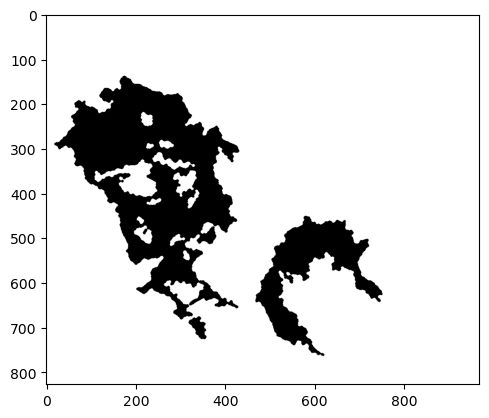

shape of array before: (827, 969)
shape of array after: (286, 190)


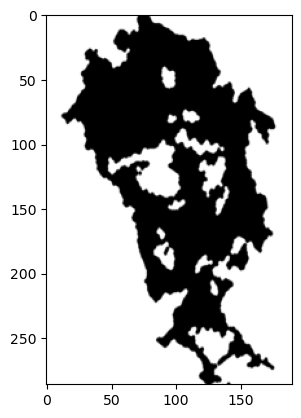

In [19]:

# Rescale and crop the smoothed array to the desired resolution and bounding box


output_resolution = 250  # Desired output resolution in meters
output_CRS = 'EPSG:3857'  # Output CRS
output_bbox = (144.73, -41.77, 145.155, -41.29)  # Output bounding box


ds = rxr.open_rasterio(image_path, masked=True)
crs = ds.rio.crs
transform = ds.rio.transform()

# Plot the current fire mask
smoothed1 = smoothed.astype(np.uint8)
plt.imshow(smoothed1, cmap='gray_r')
plt.show()
print('shape of array before: {}'.format(smoothed1.shape))

# Plot the cropped fire mask
smoothed_rescaled = resample_raster_to_grid(
    raster_data=smoothed1, output_bbox=output_bbox,
    resolution=output_resolution, transform=transform, crs=crs
)
print('shape of array after: {}'.format(smoothed_rescaled.shape))
plt.imshow(smoothed_rescaled, cmap='gray_r')
plt.show()


Looks good to me. We zoomed in on the bigger fire on the left as we will focus on this fire for the fire simulation. We can now save the new mask. I am not sure what would be better to work with the cleaned or the raw fire mask. Because the small holes might represent rocky areas that are nonflammable. But that is okay, for the fire simulation the goal is to reach a decent accuracy of maybe +/- 20% of the actual area. 

In [20]:
smoothed_rescaled = smoothed_rescaled.astype(np.uint8)
np.save('output/burnt_area_mask.npy', smoothed_rescaled)
burnt_area_mask = np.load('output/burnt_area_mask.npy')

### Turn raster data into vector data

Finally, we also save the burnt area as a shapefile in case it is going to be used for other applications.

In [21]:
# Get spatial metadata
transform = ds.rio.transform()
crs = ds.rio.crs

# Convert binary mask to int (0 and 1)
mask_burn = smoothed.astype(np.uint8)

# Extract shapes (polygons) from the mask
results = shapes(mask_burn, mask=mask_burn == 1, transform=transform)

# Convert to shapely geometries
geoms = [shape(geom) for geom, val in results if val == 1]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs)

# Optional: Add a 'burnt' column for clarity
gdf["burnt"] = 1

# Save to GeoPackage or Shapefile
gdf.to_file("output/burnt_area.shp", driver= "ESRI Shapefile")


# Blog post 1 goes until here

---

# Now additional data is downloaded (slope and wind) and all data is collected and saved in a dictionary for Blog post 2 + some work that was not used in the end

## Getting the ignition point of the fire: Also includes collecting fire data  VIIRS and MODIS infrared anomaly detection

We create a plot that shows detected fires on top of the fire mask. The detected fire points are then grouped by day to see where the fire started and how it spread.

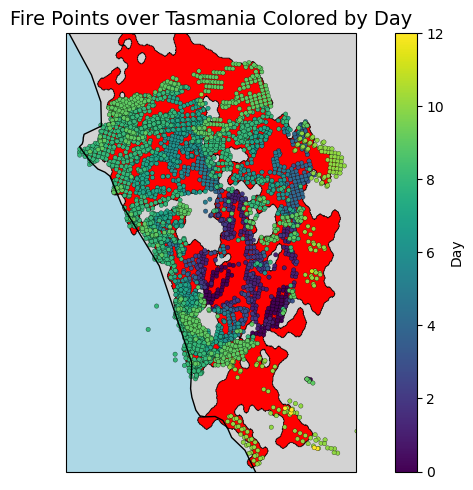

In [22]:
# Note that the dbf file from VIIRS and MODIS were downloaded from the NASA FIRMS website. But are also available in the data/FP folder.

# Step 1: Read the DBF file
gdf = gpd.read_file('data/FP/fire_nrt_J1V-C2_599167.dbf')

# Step 2: Select relevant columns and ensure they're named correctly
df = gdf[['LONGITUDE', 'LATITUDE', 'ACQ_DATE']]  # rename columns if necessary
df = df.dropna(subset=['LONGITUDE', 'LATITUDE', 'ACQ_DATE'])
df.sort_values(by='ACQ_DATE', inplace=True)

# Step 2.5: Convert day column to integer days starting from 0
df['ACQ_DATE'] = pd.to_datetime(df['ACQ_DATE'])
#print(df['ACQ_DATE'])
df['ACQ_DATE'] = (df['ACQ_DATE'] - df['ACQ_DATE'].min()).dt.days

# Step 3: Get list of unique days
unique_days = df['ACQ_DATE'].unique()

# Step 4: Set up the plot
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([144.73, 145.155, -41.77, -41.29], crs=ccrs.PlateCarree())  # Zoom to Tasmania

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

# Step 4.0: Add burnt area polygons
polygons = gpd.read_file('burnt_area.shp')
polygons = polygons.to_crs(epsg=4326)  # WGS84 = PlateCarree
polygons.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())


# Step 4: Scatter plot with colormap
scatter = ax.scatter(
    df['LONGITUDE'],
    df['LATITUDE'],
    c=df['ACQ_DATE'],
    cmap='viridis',     # or 'plasma', 'inferno', 'coolwarm', etc.
    s=10,
    edgecolor='k',
    linewidth=0.2,
    transform=ccrs.PlateCarree()
)

# Step 5: Colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Day')
cbar.ax.tick_params(labelsize=10)

# Title
ax.set_title('Fire Points over Tasmania Colored by Day', fontsize=14)

plt.tight_layout()
plt.show()

We can see in dark blue that there most likely 2 points where the fire started. There are quite large areas where we detected fire damage using the NBR values, but no fires were detected with the infrared cameras. This can have different reasons. The fire was only active outside of the observation windows or it could have been to weak for the fire to be detected. 

In [23]:
def get_files_in_folder_with_ending(folder_path, ending):
    all_files = os.listdir(folder_path)
    dbf_files = []
    for file in all_files:
        if file.endswith('.dbf'):
            dbf_files.append(folder_path+file)
    return dbf_files

FP_path = get_files_in_folder_with_ending(folder_path='data/FP/', ending='.dbf')
print(FP_path)

['data/FP/fire_nrt_J1V-C2_599167.dbf', 'data/FP/fire_nrt_J2V-C2_599168.dbf', 'data/FP/fire_nrt_M-C61_599165.dbf', 'data/FP/fire_nrt_SV-C2_599169.dbf']


In [24]:
# Step 1: Read the DBF file
def read_df(file_path):
    gdf = gpd.read_file(file_path)

    # Step 2: Select relevant columns and ensure they're named correctly
    df = gdf[['LONGITUDE', 'LATITUDE', 'ACQ_DATE', 'ACQ_TIME', 'INSTRUMENT','SATELLITE']]  # rename columns if necessary
    rename_keys = {'LONGITUDE':'longitude', 'LATITUDE':'latitude', 'ACQ_DATE':'day', 'ACQ_TIME':'time', 'INSTRUMENT':'instrument'}
    df = df.rename(columns=rename_keys)
    return df

# Combine all the dataframes into one dataframe
for i in range(len(FP_path)):
    if i==0:
        df = read_df(FP_path[i])
    else:
        df = pd.concat([df, read_df(FP_path[i])])

df.time = df.time.astype('int64')

df['hour'] = df['time'] // 100
df['minute'] = df['time'] % 100
df['time_delta'] = pd.to_timedelta(df['hour'], unit='h') + pd.to_timedelta(df['minute'], unit='m')

# Add timedelta to date
df['datetime'] = df['day'] + df['time_delta']

# Get the earliest date
start_date = df['datetime'].min()

# Calculate day number (as integer days since the start_date)
df['day_number'] = (df['datetime'] - start_date).dt.days

# Optional: drop the helper columns if you don't need them
df.drop(columns=['hour', 'minute', 'time_delta'], inplace=True)

df.head()

longitude  latitude        day  time instrument SATELLITE  \
0  144.93967 -41.57370 2025-02-03  1528      VIIRS       N20   
1  144.93419 -41.57304 2025-02-03  1528      VIIRS       N20   
2  144.95056 -41.57501 2025-02-03  1528      VIIRS       N20   
3  145.03802 -41.58548 2025-02-03  1528      VIIRS       N20   
4  145.31905 -41.61866 2025-02-03  1528      VIIRS       N20   

             datetime  day_number  
0 2025-02-03 15:28:00           1  
1 2025-02-03 15:28:00           1  
2 2025-02-03 15:28:00           1  
3 2025-02-03 15:28:00           1  
4 2025-02-03 15:28:00           1

Let's see at what times the fires were recorded

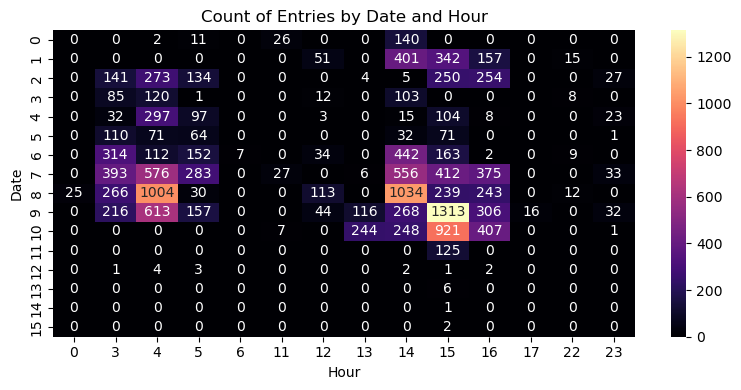

In [25]:
# Break into day and hour
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Group
heatmap_data = df.groupby(['day_number', 'hour']).size().unstack(fill_value=0)

import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='magma', annot=True, fmt='d')
plt.title('Count of Entries by Date and Hour')
plt.xlabel('Hour')
plt.ylabel('Date')
plt.tight_layout()
plt.show()


At this point, I was still considering using these timestaps to map the fire at different times such that we could check the simulation at different time stamps. I think this is definitely possible, but the scope of this project already barely fits into 2 blog posts.

Let's instead look at where the fire started

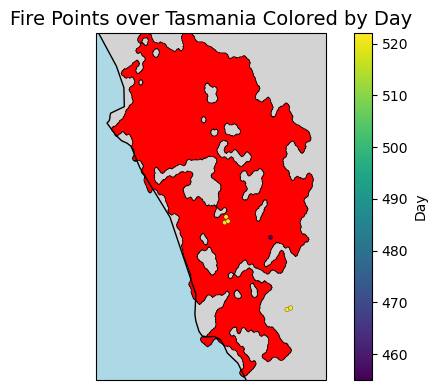

In [26]:
df_trimmed = df[(df['day_number'] < 1) & (df['time'] < 530)]

# Step 4: Set up the plot
fig = plt.figure(figsize=(6, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([144.73, 145.155, -41.77, -41.29], crs=ccrs.PlateCarree())  # Zoom to Tasmania

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

# Step 4.0: Add burnt area polygons
polygons = gpd.read_file('burnt_area.shp')
polygons = polygons.to_crs(epsg=4326)  # WGS84 = PlateCarree
polygons.plot(ax=ax, facecolor='red', edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

ax.set_xlabel('longitude')
# Step 4: Scatter plot with colormap
scatter = ax.scatter(
    df_trimmed['longitude'],
    df_trimmed['latitude'],
    c=df_trimmed['time'],
    cmap='viridis',     # or 'plasma', 'inferno', 'coolwarm', etc.
    s=10,
    edgecolor='k',
    linewidth=0.2,
    transform=ccrs.PlateCarree()
)

# Step 5: Colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Day')
cbar.ax.tick_params(labelsize=10)

# Title
ax.set_title('Fire Points over Tasmania Colored by Day', fontsize=14)

plt.tight_layout()
plt.show()

In [27]:
df_trimmed.head(5)

longitude  latitude        day  time instrument SATELLITE  \
1  145.36433 -41.87214 2025-02-03   455      VIIRS       N21   
2  145.05249 -41.57241 2025-02-03   455      VIIRS       N21   
0  144.97020 -41.54413 2025-02-03   522      VIIRS         N   
1  144.96771 -41.55203 2025-02-03   522      VIIRS         N   
2  144.97389 -41.55006 2025-02-03   522      VIIRS         N   

             datetime  day_number        date  hour  
1 2025-02-03 04:55:00           0  2025-02-03     4  
2 2025-02-03 04:55:00           0  2025-02-03     4  
0 2025-02-03 05:22:00           0  2025-02-03     5  
1 2025-02-03 05:22:00           0  2025-02-03     5  
2 2025-02-03 05:22:00           0  2025-02-03     5

In [28]:
# We pick one of the fire points by hand and save it
fire_points_export = np.array([[145.05249, -41.57241],[144.97389, -41.55006]])
np.save('fire_points_export.npy', fire_points_export)


# Additional Data

In this section, we gather all the data that is needed for the simulation. We crop it to the simulation area and to our desired resolution.

### Wind

Starting with the wind data. This might take a little while around 5-15min

In [174]:
# There is hourly data available for wind and temperature. We can use the ERA5 dataset to get the data for the area of interest. 
# However, especially for the wind data, I am not sure about the accuracy to measure the wind in the remote area with 0.1 degree resolution.
# We average over the spatial solution and just get an average value

# Note the download takes surprisingly long. 5-10min

dataset = "reanalysis-era5-land"
request = {
    "variable": [
        "2m_temperature",
        "10m_u_component_of_wind",
        "10m_v_component_of_wind"
    ],
    "year": "2025",
    "month": "02",
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [-41, 144, -42, 146]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-26 21:19:55,612 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-26 21:19:55,613 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-26 21:19:55,847 INFO Request ID is 47f893ab-5de3-4b9d-87b2-271b0c82e3d5
2025-04-26 21:19:55,923 INFO status has been updated to accepted
2025-04-26 21:20:18,088 INFO status has been updated to running
2025-04-26 21:22:48,888 INFO status has been updated to successful


d7740c65662aa61e56edf796ab5a8e82.nc:   0%|          | 0.00/471k [00:00<?, ?B/s]

'd7740c65662aa61e56edf796ab5a8e82.nc'

In [196]:
file_path = 'd7740c65662aa61e56edf796ab5a8e82.nc'
ds = xr.open_dataset(file_path)

times = ds['valid_time'].values # in 1h steps

# Create the arrays for wind and temp
temp_avg = np.zeros([times.size])
wind_u_avg = np.zeros([times.size])
wind_v_avg = np.zeros([times.size])

for i,t in enumerate(times):
    data_slice = ds.sel(valid_time=t)
    t2m = data_slice['t2m'].values.ravel()
    u10 = data_slice['u10'].values.ravel()
    v10 = data_slice['v10'].values.ravel()

    # Fill NaNs with mean
    t2m = np.where(np.isnan(t2m), np.nanmean(t2m), t2m)
    u10 = np.where(np.isnan(u10), np.nanmean(u10), u10)
    v10 = np.where(np.isnan(v10), np.nanmean(v10), v10)

    # Interpolate to your fine grid
    temp_avg[i] = t2m.mean()
    wind_u_avg[i] = u10.mean()
    wind_v_avg[i] = v10.mean()


In [ ]:
# We got 2 days too much before the fire and one day too much after the fire. We remove them.
temp_avg = temp_avg[48:-(24)]
wind_u_avg = wind_u_avg[48:-(24)]
wind_v_avg = wind_v_avg[48:-(24)]
times = times[48:-(24)]

### NDVI, NDWI

Let's get the NDVI from before the fire and resample it to the simulation area

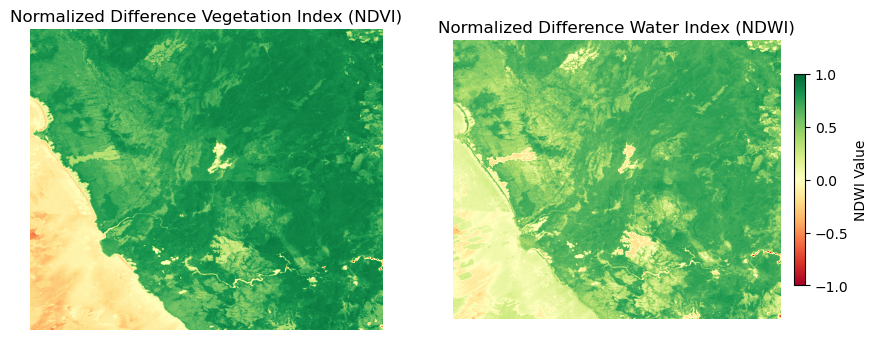

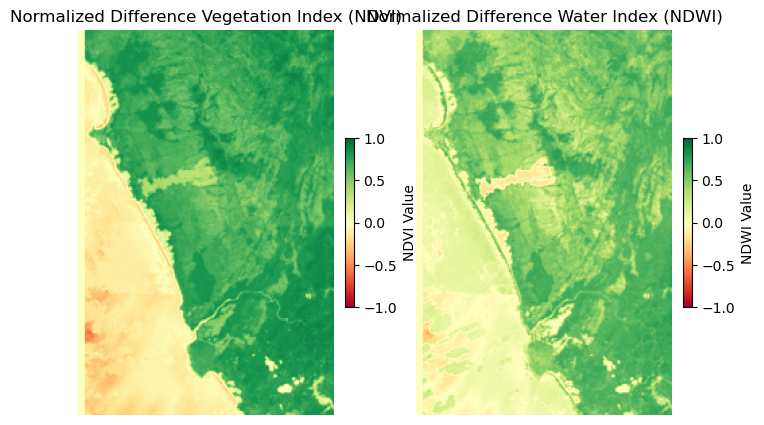

In [29]:
tif_path = "output/cloud_free_sentinel2.tif"

# === 1. get the raster band ===
with rasterio.open(tif_path) as src:
    profile = src.profile
    bands = src.read()
    band_names = ['B2', 'B3', 'B4', 'B8', 'B12', 'SCL']

    # Band indices (assuming Sentinel-2 style band order)
    band_B4 = bands[2].astype('float32')  # Red
    band_B8 = bands[3].astype('float32')  # NIR
    band_B12 = bands[4].astype('float32')  # SWIR

    # === 2. Calculate NDVI and NDWI ===
    ndvi = (band_B8 - band_B4) / (band_B8 + band_B4 + 1e-10)  # Add small value to avoid division by zero
    ndwi = (band_B8 - band_B12) / (band_B8 + band_B12 + 1e-10)  # This is actually the same as NBR

# Apply the water mask to NDVI
#ndvi = np.where(combined_water_mask == 1, np.nan, ndvi)
#ndwi = np.where(combined_water_mask == 1, np.nan, ndwi)

# Plot NDVI and NDWI    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot NDVI
axes[0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title("Normalized Difference Vegetation Index (NDVI)")
axes[0].axis("off")
# Plot NDWI
axes[1].imshow(ndwi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title("Normalized Difference Water Index (NDWI)")
axes[1].axis("off")
# Add colorbar for NDVI
cbar = plt.colorbar(axes[1].imshow(ndwi, cmap='RdYlGn', vmin=-1, vmax=1), ax=axes[1], fraction=0.03, pad=0.04)
cbar.set_label("NDWI Value")
# Show the plot
plt.show()




output_resolution = 250  # Desired output resolution in meters
input_resolution = 100  # Input resolution in meters
input_CRS = 'EPSG:4326'  # Input CRS
output_CRS = 'EPSG:3857'  # Output CRS
output_bbox = (144.73, -41.77, 145.155, -41.29)  # Output bounding box


ds = rxr.open_rasterio(image_path, masked=True)
crs = ds.rio.crs
transform = ds.rio.transform()

# Plot the cropped fire mask
ndvi_resampled = resample_raster_to_grid(
    raster_data=ndvi, output_bbox=output_bbox,
    resolution=output_resolution, transform=transform, crs=crs
)

ndwi_resampled = resample_raster_to_grid(
    raster_data=ndwi, output_bbox=output_bbox,
    resolution=output_resolution, transform=transform, crs=crs
)

# Plot NDVI and NDWI    
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
# Plot NDVI
axes[0].imshow(ndvi_resampled, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title("Normalized Difference Vegetation Index (NDVI)")
axes[0].axis("off")
# Plot NDWI
axes[1].imshow(ndwi_resampled, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title("Normalized Difference Water Index (NDWI)")
axes[1].axis("off")
# Add colorbar for NDVI
cbar = plt.colorbar(axes[1].imshow(ndwi_resampled, cmap='RdYlGn', vmin=-1, vmax=1), ax=axes[1], fraction=0.03, pad=0.04)
cbar1 = plt.colorbar(axes[0].imshow(ndvi_resampled, cmap='RdYlGn', vmin=-1, vmax=1), ax=axes[0], fraction=0.03, pad=0.04)
cbar1.set_label("NDVI Value")   
cbar.set_label("NDWI Value")
# Show the plot
plt.show()



### Slope

In [30]:
def dem_from_tif_to_grid(tif_path='elevation_COPERNICUS.tif',min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat, n_y=n_y,n_x=n_x):
        # === 1. get the raster band ===
    with rasterio.open(tif_path) as src:
        profile = src.profile
        DEM = src.read()

    # === 3. Crop to bounding box ===

    # Define bbox polygon as GeoJSON-like dict
    bbox_poly = {
        "type": "Polygon",
        "coordinates": [[
            [min_lon, min_lat],
            [min_lon, max_lat],
            [max_lon, max_lat],
            [max_lon, min_lat],
            [min_lon, min_lat]
        ]]
    }

    with rasterio.open(tif_path) as src:
        # Use mask to crop NDVI (by masking manually since NDVI isn't in file)
        DEM_masked, transform = mask(src, [bbox_poly], crop=True)
        # Recalculate NDVI using cropped bands


    dst_shape = (n_y, n_x)
    dst_transform = rasterio.transform.from_origin(min_x, max_y, resolution, resolution)

    DEM_resampled = np.empty(dst_shape, dtype='float32')

    reproject(
        source=DEM_masked,
        destination=DEM_resampled,
        src_transform=transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs="EPSG:3857",
        resampling=Resampling.bilinear
    )

    print(f"Final NDVI array shape: {DEM_resampled.shape}")
    return DEM_resampled


NameError: name 'min_lon' is not defined

In [204]:
# Slope data is easily available from the Copernicus DEM. We can use the GLO30 dataset, which is a 30m resolution DEM.
s2 = (
  #ee.Image('AU/GA/DEM_1SEC/v10/DEM-S'))
  ee.ImageCollection('COPERNICUS/DEM/GLO30')
  .filterBounds(ee.Geometry.Rectangle([144.74, -41.77, 145.155, -41.29]))
  .median())

#elevation = s2.select('elevation')
elevation = s2.select('DEM')
elevation_vis = {
  'min': 0.0,
  'max': 1500.0,
  'palette': ['0000ff','00ffff','ffff00','ff0000','ffffff']
}


m = geemap.Map()
m.set_center(145.323,-41.523, 9)
# Add Layers: RGB and NBR
m.addLayer(elevation, elevation_vis, 'DEM')
#m

In [203]:

geemap.ee_export_image(elevation, filename='output/elevation_COPERNICUS.tif', scale=50, file_per_band=False, region=ee.Geometry.Rectangle([144.13, -41.1, 145.255, -41.9]))


Generating URL ...
Please wait ...
Data downloaded to c:\Users\juliu\Desktop\Coding\Bushfire\output\elevation_COPERNICUS.tif


Crop it to the simulation

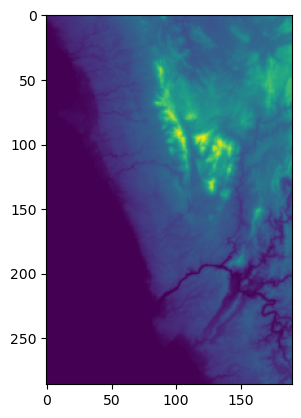

In [32]:
image_path = "elevation_COPERNICUS.tif"
output_resolution = 250  # Desired output resolution in meters
input_resolution = 100  # Input resolution in meters
output_CRS = 'EPSG:3857'  # Output CRS
output_bbox = (144.73, -41.77, 145.155, -41.29)  # Output bounding box


ds = rxr.open_rasterio(image_path, masked=True)
crs = ds.rio.crs
transform = ds.rio.transform()
slope = ds[0].values
# Plot the cropped fire mask
slope_resampled = resample_raster_to_grid(
    raster_data=slope, output_bbox=output_bbox,
    resolution=output_resolution, transform=transform, crs=crs
)
plt.imshow(slope_resampled)
plt.show()

### The whole CA into a dict

That was a lot of work. Now, we can save all the data into a dictionary for the fire simulation. 

In [232]:
min_lon, min_lat, max_lon, max_lat = output_bbox

In [238]:
crs = "EPSG:4326"
coords_dict = {
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_lon': min_lon,
    'max_lon': max_lon,
    'resolution': resolution,
    'x_grid': x_coords,
    'y_grid': y_coords
}
CA_grid={
    'CRS':crs,
    'coords':coords_dict,
    'NDVI': ndvi_resampled,
    'NDWI': ndwi_resampled,
    'slope': slope_resampled,
    'times': times,
    'temperatue':temp_avg,
    'wind_u': wind_u_avg,
    'wind_v': wind_v_avg,
    'burnt_area': smoothed_rescaled,
    'ignition_points': fire_points_export,
    }


In [240]:
with open('output/CA_data.pkl', 'wb') as f:
    pickle.dump(CA_grid, f)

Kind of crazy that all the data we gathered in the end turns out to be only a bit more than 1MB. Let's do a quick review of what we have done in this notebook:
* First, we gained access to Google Earth Explorer to download satellite images
* Then, we calculated the burn scare of a recent fire in Tasmania
* Next, we cropped and resampled the image to a rectangle with resolution of 250m
* We downloaded wind, slope, ndwi, ndvi data and resampled them to 250m resoltuion. We also determined the start point of the fire
* Finally, we stored all the data in a dictionary for the fire simulation

Get excited for the next notebook.